### Assignment 9

#### Part 1:
A pipeline network is depicted in the directed graph below. Specifically, the pipeline network is represented as a set of nodes (representing pumping stations) connected by a series of arrows (representing pipelines between pumping stations). Flow through the pipeline is unidirectional from node to node as indicated by the arrows. Each pipeline’s capacity (maximum rate of flow) is indicated beside the corresponding arrow.
<img src="pipeline.png">

In [1]:
from __future__ import print_function
from ortools.graph import pywrapgraph

def main():
  """MaxFlow simple interface"""

  # Define three parallel arrays: start_nodes, end_nodes, and the capacities
  # between each pair. For instance, the arc from node 0 to node 1 has a
  # capacity of 1.

  start_nodes = [0, 0, 0, 1, 2, 2, 2, 3, 4, 5, 6]
  end_nodes = [1, 2, 3, 4, 4, 5, 6, 6, 7, 7, 7]
  capacities = [2, 3, 2, 1, 1, 2, 1, 1, 2, 3, 2]

  # Instantiate a SimpleMaxFlow solver.
  max_flow = pywrapgraph.SimpleMaxFlow()
  # Add each arc.
  for i in range(0, len(start_nodes)):
    max_flow.AddArcWithCapacity(start_nodes[i], end_nodes[i], capacities[i])

  # Find the maximum flow between node 0 and node 7.
  if max_flow.Solve(0, 7) == max_flow.OPTIMAL:
    print('Max flow:', max_flow.OptimalFlow())
    print('')
    print('  Arc    Flow / Capacity')
    for i in range(max_flow.NumArcs()):
      print('%1s -> %1s   %3s  / %3s' % (
          max_flow.Tail(i),
          max_flow.Head(i),
          max_flow.Flow(i),
          max_flow.Capacity(i)))
    print('Source side min-cut:', max_flow.GetSourceSideMinCut())
    print('Sink side min-cut:', max_flow.GetSinkSideMinCut())
  else:
    print('There was an issue with the max flow input.')

if __name__ == '__main__':
  main()

Max flow: 5

  Arc    Flow / Capacity
0 -> 1     1  /   2
0 -> 2     3  /   3
0 -> 3     1  /   2
1 -> 4     1  /   1
2 -> 4     1  /   1
2 -> 5     2  /   2
2 -> 6     0  /   1
3 -> 6     1  /   1
4 -> 7     2  /   2
5 -> 7     2  /   3
6 -> 7     1  /   2
Source side min-cut: [0, 1, 3]
Sink side min-cut: [7, 5, 6, 2, 4]


#### Part 2
In addition to capacities, maintenance data is also available. Each day, any given pipeline may need to be shut down for a period of time for maintenance. When this occurs, the pipeline’s capacity for that day is reduced. The maintenance may be minor or major. Major maintenance requires a greater period of downtime than minor maintenance, resulting in greater reductions in capacity. The data are summarized in the table below.
<img src="maintenance.png">
Based on the maintenance data, find the expected maximum possible flow through the pipeline network. If possible, also create a distribution of maximum possible flows for any given day, month, and year.

In [2]:
from __future__ import print_function
import random
from ortools.graph import pywrapgraph

#This script simulates all 27 possible combination of flow

# Dictionary of flow paths, this dictionary contains all possible flow combinations.
# The naming convention; V0V1 represents Line V0--V1, V5V7 represents line V5--Vt, V0V3 represents line V0--V3
# No = Normal flow, Mi = Minor maintnance, Ma = Major maintanence
# For example entry 1 "V0V1NoV5V7NoV0V3No" V0--V1 line normal flow, V5--Vt line normal flow,V0--V3 line normal flow
flowPathDict = {"V0V1NoV5V7NoV0V3No":[2, 3, 2, 1, 1, 2, 1, 1, 2, 3, 2],
            "V0V1MiV5V7NoV0V3No":[1, 3, 2, 1, 1, 2, 1, 1, 2, 3, 2],
            "V0V1MaV5V7NoV0V3No":[0, 3, 2, 1, 1, 2, 1, 1, 2, 3, 2],
            "V0V1NoV5V7MiV0V3No":[2, 3, 2, 1, 1, 2, 1, 1, 2, 2, 2],
            "V0V1NoV5V7MaV0V3No":[2, 3, 2, 1, 1, 2, 1, 1, 2, 1, 2],
            "V0V1NoV5V7NoV0V3Mi":[2, 3, 1, 1, 1, 2, 1, 1, 2, 3, 2],
            "V0V1NoV5V7NoV0V3Ma":[2, 3, 0, 1, 1, 2, 1, 1, 2, 3, 2],
            "V0V1MiV5V7MiV0V3No":[1, 3, 2, 1, 1, 2, 1, 1, 2, 2, 2],
            "V0V1MiV5V7MaV0V3No":[1, 3, 2, 1, 1, 2, 1, 1, 2, 1, 2],
            "V0V1MiV5V7NoV0V3Mi":[1, 3, 1, 1, 1, 2, 1, 1, 2, 3, 2],
            "V0V1MiV5V7NoV0V3Ma":[1, 3, 0, 1, 1, 2, 1, 1, 2, 3, 2],
            "V0V1MaV5V7MiV0V3No":[0, 3, 2, 1, 1, 2, 1, 1, 2, 2, 2],
            "V0V1MaV5V7MaV0V3No":[0, 3, 2, 1, 1, 2, 1, 1, 2, 1, 2],
            "V0V1MaV5V7NoV0V3Mi":[0, 3, 1, 1, 1, 2, 1, 1, 2, 3, 2],
            "V0V1MaV5V7NoV0V3Ma":[0, 3, 0, 1, 1, 2, 1, 1, 2, 3, 2],
            "V0V1NoV5V7MiV0V3Mi":[2, 3, 1, 1, 1, 2, 1, 1, 2, 2, 2],
            "V0V1NoV5V7MiV0V3Ma":[2, 3, 0, 1, 1, 2, 1, 1, 2, 2, 2],
            "V0V1MaV5V7MaV0V3Mi":[0, 3, 1, 1, 1, 2, 1, 1, 2, 1, 2],
            "V0V1MaV5V7MaV0V3Ma":[0, 3, 0, 1, 1, 2, 1, 1, 2, 1, 2],
            "V0V1MiV5V7MiV0V3Mi":[1, 3, 1, 1, 1, 2, 1, 1, 2, 2, 2],
            "V0V1MiV5V7MiV0V3Ma":[1, 3, 0, 1, 1, 2, 1, 1, 2, 2, 2],
            "V0V1MiV5V7MaV0V3Mi":[1, 3, 1, 1, 1, 2, 1, 1, 2, 1, 2],
            "V0V1MaV5V7MiV0V3Ma":[0, 3, 0, 1, 1, 2, 1, 1, 2, 2, 2],
            "V0V1MiV5V7MaV0V3Ma":[1, 3, 0, 1, 1, 2, 1, 1, 2, 1, 2],
            "V0V1MaV5V7MiV0V3Mi":[0, 3, 1, 1, 1, 2, 1, 1, 2, 2, 2],
            "V0V1NoV5V7MaV0V3Ma":[2, 3, 0, 1, 1, 2, 1, 1, 2, 1, 2],
            "V0V1NoV5V7MaV0V3Mi":[2, 3, 1, 1, 1, 2, 1, 1, 2, 1, 2]}


# flowList = []
flowDictCombo = {}
for path, flow in flowPathDict.items():
    flowPathCapacities = flow

    def main():
      """MaxFlow simple interface."""

      # Define three parallel arrays: start_nodes, end_nodes, and the capacities
      # between each pair. For instance, the arc from node 0 to node 1 has a
      # capacity of 2 when not under maintence.

      start_nodes = [0, 0, 0, 1, 2, 2, 2, 3, 4, 5, 6]
      end_nodes = [1, 2, 3, 4, 4, 5, 6, 6, 7, 7, 7]
      capacities = flowPathCapacities

      # Instantiate a SimpleMaxFlow solver.
      max_flow = pywrapgraph.SimpleMaxFlow()
      # Add each arc.
      for i in range(0, len(start_nodes)):
        max_flow.AddArcWithCapacity(start_nodes[i], end_nodes[i], capacities[i])

      # Find the maximum flow between node 0 and node 7.
      if max_flow.Solve(0, 7) == max_flow.OPTIMAL:
        #flowList.append(max_flow.OptimalFlow())     
        flowDictCombo[path] = max_flow.OptimalFlow()    
        #print('Max flow of', path, 'is:', max_flow.OptimalFlow())

        #print('')
        #print('  Arc    Flow / Capacity')
        #for i in range(max_flow.NumArcs()):
          #print('%1s -> %1s   %3s  / %3s' % (
              #max_flow.Tail(i),
             # max_flow.Head(i),
              #max_flow.Flow(i),
              #max_flow.Capacity(i)))
        #print('Source side min-cut:', max_flow.GetSourceSideMinCut())
        #print('Sink side min-cut:', max_flow.GetSinkSideMinCut())
      else:
        print('There was an issue with the max flow input.')

    if __name__ == '__main__':
      main()

flowDictCombo

{'V0V1NoV5V7NoV0V3No': 5,
 'V0V1MiV5V7NoV0V3No': 5,
 'V0V1MaV5V7NoV0V3No': 4,
 'V0V1NoV5V7MiV0V3No': 5,
 'V0V1NoV5V7MaV0V3No': 5,
 'V0V1NoV5V7NoV0V3Mi': 5,
 'V0V1NoV5V7NoV0V3Ma': 4,
 'V0V1MiV5V7MiV0V3No': 5,
 'V0V1MiV5V7MaV0V3No': 5,
 'V0V1MiV5V7NoV0V3Mi': 5,
 'V0V1MiV5V7NoV0V3Ma': 4,
 'V0V1MaV5V7MiV0V3No': 4,
 'V0V1MaV5V7MaV0V3No': 4,
 'V0V1MaV5V7NoV0V3Mi': 4,
 'V0V1MaV5V7NoV0V3Ma': 3,
 'V0V1NoV5V7MiV0V3Mi': 5,
 'V0V1NoV5V7MiV0V3Ma': 4,
 'V0V1MaV5V7MaV0V3Mi': 4,
 'V0V1MaV5V7MaV0V3Ma': 3,
 'V0V1MiV5V7MiV0V3Mi': 5,
 'V0V1MiV5V7MiV0V3Ma': 4,
 'V0V1MiV5V7MaV0V3Mi': 5,
 'V0V1MaV5V7MiV0V3Ma': 3,
 'V0V1MiV5V7MaV0V3Ma': 4,
 'V0V1MaV5V7MiV0V3Mi': 4,
 'V0V1NoV5V7MaV0V3Ma': 4,
 'V0V1NoV5V7MaV0V3Mi': 5}

In [5]:
from __future__ import print_function
import random
from ortools.graph import pywrapgraph
import datetime

#This script simulates 5 years worth daily flows basied on the Maintenance data

# Dictionary of flow paths, this dictionary contains all possible flow combinations.
# The naming convention; V0V1 represents Line V0--V1, V5V7 represents line V5--Vt, V0V3 represents line V0--V3
# No = Normal flow, Mi = Minor maintnance, Ma = Major maintanence
# For example entry 1 "V0V1NoV5V7NoV0V3No" V0--V1 line normal flow, V5--Vt line normal flow,V0--V3 line normal flow
flowPathDict = {"V0V1NoV5V7NoV0V3No":[2, 3, 2, 1, 1, 2, 1, 1, 2, 3, 2],
            "V0V1MiV5V7NoV0V3No":[1, 3, 2, 1, 1, 2, 1, 1, 2, 3, 2],
            "V0V1MaV5V7NoV0V3No":[0, 3, 2, 1, 1, 2, 1, 1, 2, 3, 2],
            "V0V1NoV5V7MiV0V3No":[2, 3, 2, 1, 1, 2, 1, 1, 2, 2, 2],
            "V0V1NoV5V7MaV0V3No":[2, 3, 2, 1, 1, 2, 1, 1, 2, 1, 2],
            "V0V1NoV5V7NoV0V3Mi":[2, 3, 1, 1, 1, 2, 1, 1, 2, 3, 2],
            "V0V1NoV5V7NoV0V3Ma":[2, 3, 0, 1, 1, 2, 1, 1, 2, 3, 2],
            "V0V1MiV5V7MiV0V3No":[1, 3, 2, 1, 1, 2, 1, 1, 2, 2, 2],
            "V0V1MiV5V7MaV0V3No":[1, 3, 2, 1, 1, 2, 1, 1, 2, 1, 2],
            "V0V1MiV5V7NoV0V3Mi":[1, 3, 1, 1, 1, 2, 1, 1, 2, 3, 2],
            "V0V1MiV5V7NoV0V3Ma":[1, 3, 0, 1, 1, 2, 1, 1, 2, 3, 2],
            "V0V1MaV5V7MiV0V3No":[0, 3, 2, 1, 1, 2, 1, 1, 2, 2, 2],
            "V0V1MaV5V7MaV0V3No":[0, 3, 2, 1, 1, 2, 1, 1, 2, 1, 2],
            "V0V1MaV5V7NoV0V3Mi":[0, 3, 1, 1, 1, 2, 1, 1, 2, 3, 2],
            "V0V1MaV5V7NoV0V3Ma":[0, 3, 0, 1, 1, 2, 1, 1, 2, 3, 2],
            "V0V1NoV5V7MiV0V3Mi":[2, 3, 1, 1, 1, 2, 1, 1, 2, 2, 2],
            "V0V1NoV5V7MiV0V3Ma":[2, 3, 0, 1, 1, 2, 1, 1, 2, 2, 2],
            "V0V1MaV5V7MaV0V3Mi":[0, 3, 1, 1, 1, 2, 1, 1, 2, 1, 2],
            "V0V1MaV5V7MaV0V3Ma":[0, 3, 0, 1, 1, 2, 1, 1, 2, 1, 2],
            "V0V1MiV5V7MiV0V3Mi":[1, 3, 1, 1, 1, 2, 1, 1, 2, 2, 2],
            "V0V1MiV5V7MiV0V3Ma":[1, 3, 0, 1, 1, 2, 1, 1, 2, 2, 2],
            "V0V1MiV5V7MaV0V3Mi":[1, 3, 1, 1, 1, 2, 1, 1, 2, 1, 2],
            "V0V1MaV5V7MiV0V3Ma":[0, 3, 0, 1, 1, 2, 1, 1, 2, 2, 2],
            "V0V1MiV5V7MaV0V3Ma":[1, 3, 0, 1, 1, 2, 1, 1, 2, 1, 2],
            "V0V1MaV5V7MiV0V3Mi":[0, 3, 1, 1, 1, 2, 1, 1, 2, 2, 2],
            "V0V1NoV5V7MaV0V3Ma":[2, 3, 0, 1, 1, 2, 1, 1, 2, 1, 2],
            "V0V1NoV5V7MaV0V3Mi":[2, 3, 1, 1, 1, 2, 1, 1, 2, 1, 2]}


flowListPath = []
flowListCapacity = []
n = 0
# Loop through 1825 days (5 years) of a daily simulation
while n < 1825:    

    #Use random numbers to determine if Line V0 - V1 is under maintenance and if it's major or minor
    r1 = random.uniform(0,1)
    if r1 >= 0.95:
        r11 = random.uniform(0,1) 
        if r11 >= 0.8:
            V0V1 = "V0V1Mi"
        else:
            V0V1 = "V0V1Ma"
    else:
        V0V1 = "V0V1No"    

    #Use random numbers to determine if Line V5 - Vt is under maintenance and if it's major or minor       
    r2 = random.uniform(0,1)
    if r2 >= 0.92:
        r22 = random.uniform(0,1) 
        if r22 > 0.5:
            V5V7 = "V5V7Mi"
        else:
            V5V7 = "V5V7Ma"
    else:
        V5V7 = "V5V7No"

    #Use random numbers to determine if Line V0 - V3 is under maintenance and if it's major or minor
    r3 = random.uniform(0,1)
    if r3 >= 0.95:
        r33 = random.uniform(0,1) 
        if r33 >= 0.8:
            V0V3 = "V0V3Mi"
        else:
            V0V3 = "V0V3Ma"
    else:
        V0V3 = "V0V3No"
    #Concatinate V0-V1, V5-Vt and V0-V3 status to pull capacities from dictionary


    flowPath = V0V1+V5V7+V0V3

    flowPathCapacities = flowPathDict[flowPath] 
    

    def main():
      """MaxFlow simple interface."""

      # Define three parallel arrays: start_nodes, end_nodes, and the capacities
      # between each pair. For instance, the arc from node 0 to node 1 has a
      # capacity of 2 when not under maintence.

      start_nodes = [0, 0, 0, 1, 2, 2, 2, 3, 4, 5, 6]
      end_nodes = [1, 2, 3, 4, 4, 5, 6, 6, 7, 7, 7]
      capacities = flowPathCapacities

      # Instantiate a SimpleMaxFlow solver.
      max_flow = pywrapgraph.SimpleMaxFlow()
      # Add each arc.
      for i in range(0, len(start_nodes)):
        max_flow.AddArcWithCapacity(start_nodes[i], end_nodes[i], capacities[i])

      # Find the maximum flow between node 0 and node 7.
      if max_flow.Solve(0, 7) == max_flow.OPTIMAL:
        #Add daily flowpath and daily capacity into a list    
        flowListCapacity.append(max_flow.OptimalFlow())
        flowListPath.append(flowPath)
        #print('Max flow of', flowPath, 'is:', max_flow.OptimalFlow())

        #print('')
        #print('  Arc    Flow / Capacity')
        #for i in range(max_flow.NumArcs()):
          #print('%1s -> %1s   %3s  / %3s' % (
              #max_flow.Tail(i),
             # max_flow.Head(i),
              #max_flow.Flow(i),
              #max_flow.Capacity(i)))
        #print('Source side min-cut:', max_flow.GetSourceSideMinCut())
        #print('Sink side min-cut:', max_flow.GetSinkSideMinCut())
      else:
        print('There was an issue with the max flow input.')

    if __name__ == '__main__':
      main()
    n += 1
print('done')

done


In [7]:
from IPython.display import display
import pandas as pd
import datetime

# Create 5 years of dates for simulation
base = datetime.datetime.strptime('2020-06-20', '%Y-%m-%d')
step = datetime.timedelta(days=1)
dateList = []
i = 0
while i < 1825:
    dateList.append(base)
    base += step
    i += 1
    
# Create data frame from Dates, Pipline Status and Pipeline flow
df = pd.DataFrame(list(zip(dateList, flowListPath, flowListCapacity)), columns = ["Date", "Pipeline Status", "Pipeline Flow"])
# Turn pipeline combos dictionary into dataframe 
dfFlowCombos=pd.DataFrame(flowDictCombo.items(),columns=['Pipeline Status',"Pipeline Flow"])


# Create columns to commuicate maintenace status of each pipeline
def V0V1(row):
    if row["Pipeline Status"][4:6] == "No":
        return "None"
    if row["Pipeline Status"][4:6] == "Mi":
        return "Minor"
    if row["Pipeline Status"][4:6] == "Ma":
        return "Major"
df['V0--V1 Pipeline Maintenance'] = df.apply(lambda row: V0V1(row), axis = 1)
dfFlowCombos['V0--V1 Pipeline Maintenance'] = dfFlowCombos.apply(lambda row: V0V1(row), axis = 1)

def V5V7(row):
    if row["Pipeline Status"][10:12] == "No":
        return "None"
    if row["Pipeline Status"][10:12] == "Mi":
        return "Minor"
    if row["Pipeline Status"][10:12] == "Ma":
        return "Major"
df['V5--Vt Pipeline Maintenance'] = df.apply(lambda row: V5V7(row), axis = 1)
dfFlowCombos['V5--Vt Pipeline Maintenance'] = dfFlowCombos.apply(lambda row: V5V7(row), axis = 1)

def V0V3(row):
    if row["Pipeline Status"][16:] == "No":
        return "None"
    if row["Pipeline Status"][16:] == "Mi":
        return "Minor"
    if row["Pipeline Status"][16:] == "Ma":
        return "Major"
df['V0--V3 Pipeline Maintenance'] = df.apply(lambda row: V0V3(row), axis = 1)
dfFlowCombos['V0--V3 Pipeline Maintenance'] = dfFlowCombos.apply(lambda row: V0V3(row), axis = 1)

#Rearrange dataframe columns for clearity 
dfPipeline = df[["Date", "Pipeline Status", "V0--V1 Pipeline Maintenance", "V5--Vt Pipeline Maintenance", "V0--V3 Pipeline Maintenance","Pipeline Flow"]]
dfFlowCombos=dfFlowCombos[["Pipeline Status", "V0--V1 Pipeline Maintenance", "V5--Vt Pipeline Maintenance", "V0--V3 Pipeline Maintenance","Pipeline Flow"]]
#Display all combinations
display(dfFlowCombos)
#Display first 5 days of simulations
display(dfPipeline.head())

,Pipeline Status,V0--V1 Pipeline Maintenance,V5--Vt Pipeline Maintenance,V0--V3 Pipeline Maintenance,Pipeline Flow
0,V0V1NoV5V7NoV0V3No,None,None,None,5
1,V0V1MiV5V7NoV0V3No,Minor,None,None,5
2,V0V1MaV5V7NoV0V3No,Major,None,None,4
3,V0V1NoV5V7MiV0V3No,None,Minor,None,5
4,V0V1NoV5V7MaV0V3No,None,Major,None,5
5,V0V1NoV5V7NoV0V3Mi,None,None,Minor,5
6,V0V1NoV5V7NoV0V3Ma,None,None,Major,4
7,V0V1MiV5V7MiV0V3No,Minor,Minor,None,5
8,V0V1MiV5V7MaV0V3No,Minor,Major,None,5
9,V0V1MiV5V7NoV0V3Mi,Minor,None,Minor,5


,Date,Pipeline Status,V0--V1 Pipeline Maintenance,V5--Vt Pipeline Maintenance,V0--V3 Pipeline Maintenance,Pipeline Flow
0,2020-06-20,V0V1MaV5V7NoV0V3No,Major,None,None,4
1,2020-06-21,V0V1NoV5V7NoV0V3Ma,None,None,Major,4
2,2020-06-22,V0V1NoV5V7NoV0V3No,None,None,None,5
3,2020-06-23,V0V1NoV5V7NoV0V3No,None,None,None,5
4,2020-06-24,V0V1NoV5V7NoV0V3No,None,None,None,5


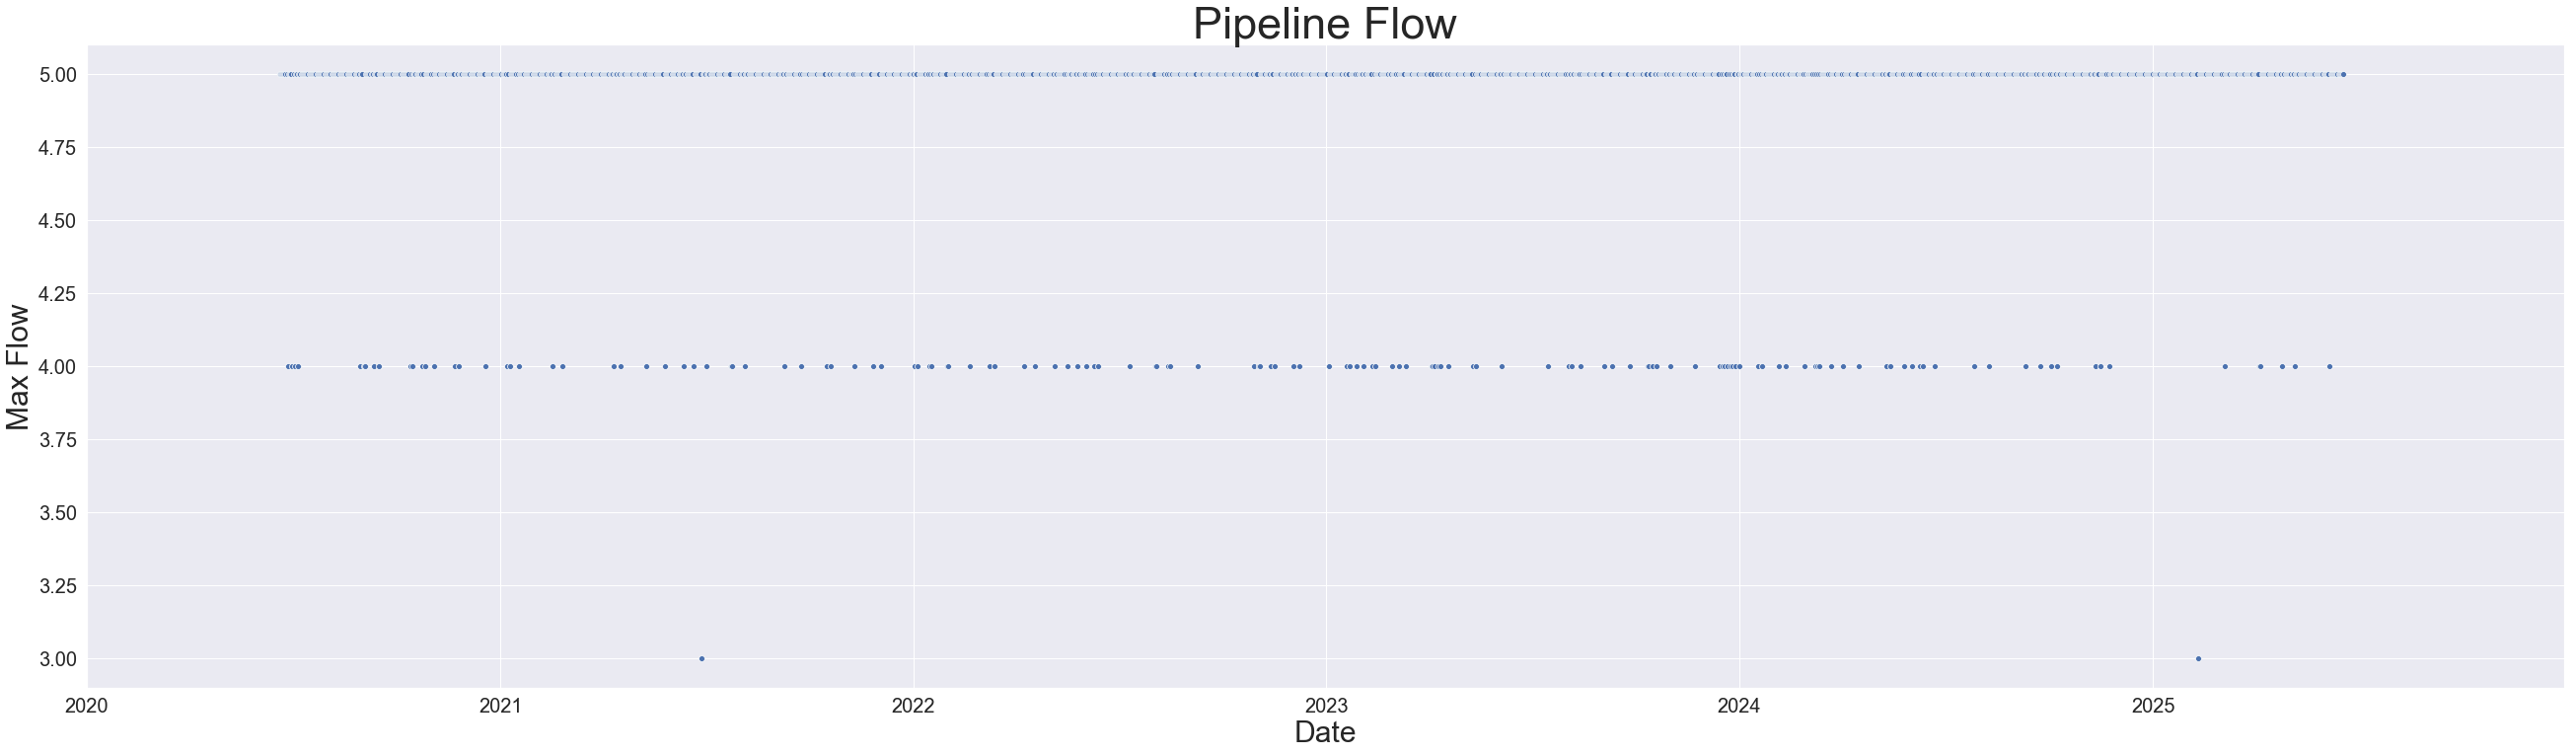

In [215]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
dims = (45, 12)
fig, ax = plt.subplots(figsize=dims)
x = sns.scatterplot(x="Date", y="Pipeline Flow", data = dfPipeline,ax=ax)
x.axes.set_title("Pipeline Flow",fontsize=45)
x.set(xlim=("2020-01-01","2025-12-30"))
x.set_xlabel("Date",fontsize=30)
x.set_ylabel("Max Flow",fontsize=30)
x.tick_params(labelsize=20)